# COVID19 Global Forecasting (Week 4)

In this notebook, the model will be predicting the cumulative number of confirmed COVID19 cases, as well as the number of resulting fatalities, for future dates. We understand this is a serious situation, and in no way want to trivialize the human impact this crisis is causing by predicting fatalities. Our goal is to provide better methods for estimates that can assist medical and governmental institutions to prepare and adjust as pandemics unfold.

In [3]:
import numpy as np 
import pandas as pd 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
import operator
import random
import datetime as dt


import sklearn.discriminant_analysis
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import hamming_loss, accuracy_score 
from pandas import DataFrame
from datetime import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Reading CSV Files

In [0]:
datatrain = pd.read_csv('/content/drive/My Drive/Covid19/train.csv')
datatest = pd.read_csv('/content/drive/My Drive/Covid19/test.csv')

In [5]:
date = pd.to_datetime(datatrain["Date"])
datet = pd.to_datetime(datatest["Date"])
print (date)
datatrain['Date'] = pd.to_datetime(datatrain.Date)
datatest['Date'] = pd.to_datetime(datatest.Date)

0       2020-01-22
1       2020-01-23
2       2020-01-24
3       2020-01-25
4       2020-01-26
           ...    
28791   2020-04-18
28792   2020-04-19
28793   2020-04-20
28794   2020-04-21
28795   2020-04-22
Name: Date, Length: 28796, dtype: datetime64[ns]


In [6]:
datatrain.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
ldate = int(len(date))
ldatet = int(len(datet))
print("Length of training- date is", ldate)
print("Length of test- date is", ldatet)

Length of training- date is 28796
Length of test- date is 13459


In [0]:
datatrain['month'] = datatrain['Date'].dt.month
datatrain['day'] = datatrain['Date'].dt.day
datatest['month'] = datatest['Date'].dt.month
datatest['day'] = datatest['Date'].dt.day

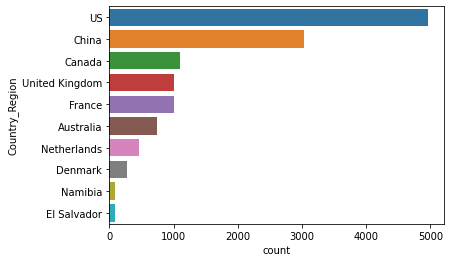

In [19]:
sns.countplot(y="Country_Region", data=datatrain,order=datatrain["Country_Region"].value_counts(ascending=False).iloc[:10].index)

Text(0.5, 0, 'Date')

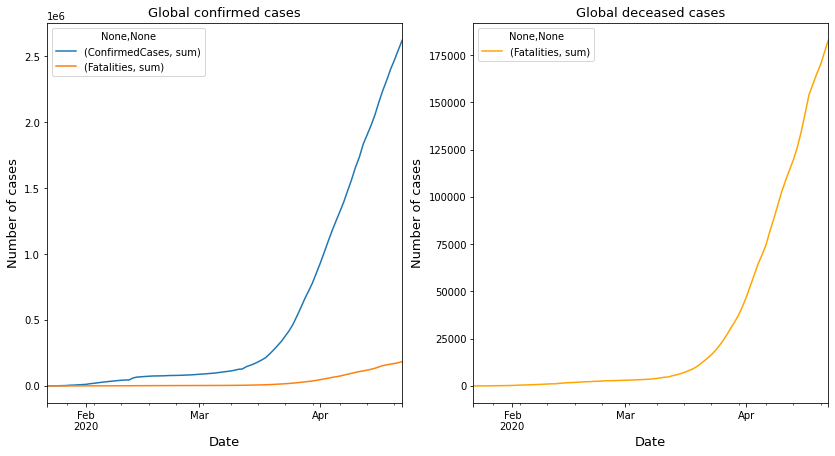

In [26]:
confirm_tot = datatrain.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_tot = datatrain.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirm_tot.join(fatalities_tot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_tot.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [0]:
train = datatrain
test = datatest

In [8]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,month,day
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,1,22
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,1,23
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,1,24
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,1,25
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,1,26


In [9]:
test.head()

,ForecastId,Province_State,Country_Region,Date,month,day
0,1,NaN,Afghanistan,2020-04-02,4,2
1,2,NaN,Afghanistan,2020-04-03,4,3
2,3,NaN,Afghanistan,2020-04-04,4,4
3,4,NaN,Afghanistan,2020-04-05,4,5
4,5,NaN,Afghanistan,2020-04-06,4,6


Feature Engineering

In [10]:
print("Datatrain")
traindays = datatrain['Date'].nunique()
print("Number of Country_Region: ", datatrain['Country_Region'].nunique())
print("Number of Province_State: ", datatrain['Province_State'].nunique())
print("Number of Days: ", traindays)

notrain = datatrain['Id'].nunique()
print("Number of datapoints in train:", notrain)
lotrain = int(notrain/traindays)
print("L Trains:", lotrain)


Datatrain
Number of Country_Region:  184
Number of Province_State:  133
Number of Days:  92
Number of datapoints in train: 28796
L Trains: 313


In [11]:
print("Datatest")
testdays = datatest['Date'].nunique()
print("Number of Days: ", testdays)
notest = datatest['ForecastId'].nunique()
print("Number of datapoints in test:", notest)
lotest = int(notest/testdays)
print("L Test:", lotest)


Datatest
Number of Days:  43
Number of datapoints in test: 13459
L Test: 313


In [12]:
zt = datet[0]
daycount = []
for i in range(0,lotrain):
    for j in range(1,traindays+1):
        daycount.append(j)

print(daycount)
print(zt)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73

In [13]:
for i in range(traindays):
    if(zt == date[i]):
        zx = i
        print(zx)
        
daytest = []
for i in range(0,lotest):
    for j in range(1,testdays+1):
        jr = zx + j
        daytest.append(jr)
print(daytest)

71
[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8

In [0]:
train.insert(8,"DayCount",daycount,False)
test.insert(6,"DayCount",daytest,False)

In [15]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,month,day,DayCount
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,1,22,1
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,1,23,2
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,1,24,3
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,1,25,4
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,1,26,5


In [16]:
traincount = int(len(train["Date"]))
testcount = int(len(test["Date"]))
print(traincount,testcount)

28796 13459


In [17]:
train.Province_State = train.Province_State.fillna(0)
empty = 0
for i in range(0,traincount):
    if(train.Province_State[i] == empty):
        train.Province_State[i] = train.Country_Region[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
test.Province_State = test.Province_State.fillna(0)
empty = 0
for i in range(0,testcount):
    if(test.Province_State[i] == empty):
        test.Province_State[i] = test.Country_Region[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Encoding of Categorical Columns

In [0]:
label = preprocessing.LabelEncoder()
train.Country_Region = label.fit_transform(train.Country_Region)
train.Province_State = label.fit_transform(train.Province_State)

In [0]:
test.Country_Region = label.fit_transform(test.Country_Region)
test.Province_State = label.fit_transform(test.Province_State)


In [0]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,month,day,DayCount
0,1,0,0,2020-01-22,0.0,0.0,1,22,1
1,2,0,0,2020-01-23,0.0,0.0,1,23,2
2,3,0,0,2020-01-24,0.0,0.0,1,24,3
3,4,0,0,2020-01-25,0.0,0.0,1,25,4
4,5,0,0,2020-01-26,0.0,0.0,1,26,5


In [0]:
test.head()

,ForecastId,Province_State,Country_Region,Date,month,day,DayCount
0,1,0,0,2020-04-02,4,2,72
1,2,0,0,2020-04-03,4,3,73
2,3,0,0,2020-04-04,4,4,74
3,4,0,0,2020-04-05,4,5,75
4,5,0,0,2020-04-06,4,6,76


In [0]:
train.rename({'Id': 'ForecastId'}, axis=1, inplace=True)

In [0]:
forecastid = test['ForecastId']
cases = train.ConfirmedCases
fatalities = train.Fatalities
train = train.drop(['ForecastId', 'Date','ConfirmedCases','Fatalities'], axis = 1)
test = test.drop(['ForecastId', 'Date'], axis = 1)

Model Building

Linear Regression

In [0]:
lr_model = LinearRegression()
lr_modelfat = LinearRegression()
lr_model.fit(train, cases)
lr_modelfat.fit(train,fatalities)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
ypredtr = lr_model.predict(train)
ypredtrft = lr_modelfat.predict(train)
err = mean_squared_error(ypredtr,cases)
err1 = mean_squared_error(ypredtrft,fatalities)
print(err,err1)

122065909.18651046 983419.2226326629


KNN

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [0]:
knn = KNeighborsRegressor(n_neighbors=3)
knnfat = KNeighborsRegressor()
knn.fit(train,cases)
knnfat.fit(train,fatalities)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [0]:
ypredtr = knn.predict(train)
ypredtrft = knnfat.predict(train)
err = mean_squared_error(ypredtr,cases)
err1 = mean_squared_error(ypredtrft,fatalities)
print(err,err1)

32680268.5749101 363699.42943742184


Decision Tree

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
param_grid = {"min_samples_split": [2, 10,15,20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
clf_dt =  GridSearchCV(dt,param_grid=param_grid,cv=10)
clf_dt.fit(train,cases) 

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [None, 2, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_sample

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt_fat = DecisionTreeRegressor()
param_grid = {"min_samples_split": [2, 10,15,20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
clf_fat =  GridSearchCV(dt_fat,param_grid=param_grid,cv=10)
clf_fat.fit(train,fatalities) 

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [None, 2, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_sample

In [0]:
ypredtr = clf_dt.predict(train)
ypredtrft = clf_fat.predict(train)
err = mean_squared_error(ypredtr,cases)
err1 = mean_squared_error(ypredtrft,fatalities)
print(err,err1)

119858287.05731232 180459.268203628


Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_jobs=-1, max_features='sqrt') #using gridsearchCV for hyperparameter tuning
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 100, 150,250],
           "max_depth" : [2,3,5,7,9],
           "min_samples_leaf" : [2, 4]}
clf_rf =  GridSearchCV(rfc,param_grid=param_grid,cv=10)
clf_rf.fit(train,cases)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [0]:
from sklearn.ensemble import RandomForestRegressor
rfc1 = RandomForestRegressor(n_jobs=-1, max_features='sqrt') 
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 100, 150,250],
           "max_depth" : [2,3,5,7,9],
           "min_samples_leaf" : [2, 4]}
clf_fat =  GridSearchCV(rfc1,param_grid=param_grid,cv=10)
clf_fat.fit(train,fatalities)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [0]:
ypredtr = clf_rf.predict(train)
ypredtrft = clf_fat.predict(train)
err = mean_squared_error(ypredtr,cases)
err1 = mean_squared_error(ypredtrft,fatalities)
print(err,err1)

119726435.93036431 970662.2025766756


XGBoost

In [0]:
regr_cs = XGBRegressor(n_estimators = 2500 , gamma = 0, learning_rate = 0.04,  random_state = 42 , max_depth = 23)
regr_ft = XGBRegressor(n_estimators = 2500 , gamma = 0, learning_rate = 0.04,  random_state = 42 , max_depth = 23)

In [0]:
regr_cs.fit(train,cases)
ypred = regr_cs.predict(train)
err = mean_squared_error(ypred,cases)
print("Training - Mean Squared Error is: ",err)

[15:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training - Mean Squared Error is:  0.00031075546047086854


In [0]:
ypred1 = regr_cs.predict(test)

In [0]:
submission = pd.DataFrame({"ForecastId": forecastid, "ConfirmedCases": ypred1},
                          columns=["ForecastId", "ConfirmedCases"])  #0.01 Kaggle result

In [0]:
submission.head()

,ForecastId,ConfirmedCases
0,1,272.998535
1,2,281.000031
2,3,299.002533
3,4,348.999146
4,5,367.000519


In [0]:
regr_ft.fit(train,fatalities)
ypred2= regr_ft.predict(train)
yptest = regr_ft.predict(test)
error = mean_squared_error(ypred2,fatalities)
print("Training - (Fatalities) Mean Squared Error is", error)

[15:51:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training - (Fatalities) Mean Squared Error is 2.953237603498639e-06


In [0]:
submission['Fatalities'] = yptest
submission = round(submission)
submission.head(10)

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0
5,6,423.0,14.0
6,7,444.0,14.0
7,8,484.0,15.0
8,9,521.0,15.0
9,10,555.0,18.0


In [0]:
submission.to_csv('submission.csv', index=False)